# Super-resolution CNN

Implementation modified from https://github.com/yjn870/SRCNN-pytorch

You can download a pretrained model from https://www.dropbox.com/s/zn4fdobm2kw0c58/srcnn_x3.pth?dl=0. Put it in the `data` folder before running this notebook.

You can also try training the model yourself with training data downloaded from https://www.dropbox.com/s/curldmdf11iqakd/91-image_x3.h5?dl=0. Put it in the `data` folder and run the following code:

```python
from lib.srcnn import train_srcnn

train_srcnn('data/91-image_x3.h5', lr=1e-4, num_epochs=400, batch_size=16, num_workers=8)
```

Feel free to play around with the parameters. Also, make sure to check out the `train_srcnn()` function to see what a basic training loop looks like.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from lib.srcnn import SRCNN

## Load the model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

state_dict = torch.load('data/srcnn_x3.pth', map_location=device)

model = SRCNN()
model.load_state_dict(state_dict)
model.eval();

## Create the input

Note that we need to resize the image to its destination size using bicubic interpollation. Also, we need to convert the RGB-image into a YCbCr-image since we only pass the **Y**-cannel of the image through the network.

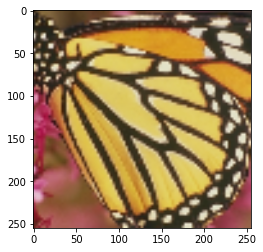

In [3]:
lr_rgb = cv2.imread('data/butterfly_LR.png')[..., ::-1]

SCALE = 3
width, height = lr_rgb.shape[:2]
lr_rgb = cv2.resize(lr_rgb, (width * SCALE,
                             height * SCALE),
                    cv2.INTER_CUBIC)

lr_ycbcr = cv2.cvtColor(lr_rgb.astype(np.float32), cv2.COLOR_RGB2YCrCb)
lr_y = lr_ycbcr[..., 0]

lr_input = torch.from_numpy(lr_y / 255.).to(device)[None, None, ...]

plt.imshow(lr_rgb)

## Pass the input through the network

In [4]:
with torch.no_grad():
    hr_output = model(lr_input)

## Transform the output back into an RGB image

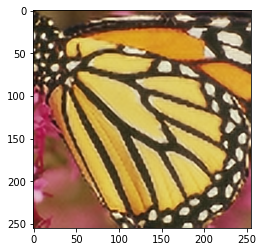

In [5]:
hr_y = (hr_output
        .clamp(0.0, 1.0)
        .mul(255.0)
        .cpu()
        .numpy()[0, 0, ...])

hr_ycbcr = np.array([hr_y,
                     lr_ycbcr[..., 1],
                     lr_ycbcr[..., 2]]).transpose([1, 2, 0])

hr_rgb = cv2.cvtColor(hr_ycbcr, cv2.COLOR_YCrCb2RGB)
hr_rgb = np.clip(hr_rgb, 0.0, 255.0).astype(np.uint8)

plt.imshow(hr_rgb)